In [59]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from scipy.stats import norm

In [60]:
images = [img for img in glob("dataset/*.png") if '_mask.png' not in img]

In [71]:
def estimate_fire_background_pdfs(images):
    fire_values, bkg_values = [], []

    for img_path in images:
        mask_path = img_path.replace('.png', '_mask.png')
        gt = cv2.imread(mask_path, 0)
        if gt is None:
            continue

        img = cv2.imread(img_path)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        H, S, V = hsv[:, :, 0], hsv[:, :, 1], hsv[:, :, 2]
        H_norm, S_norm, V_norm = H / 180.0, S / 255.0, V / 255.0

        # Probabilitas sederhana bahwa piksel merupakan api
        P_fire = (1 - H_norm) * S_norm * V_norm

        # === Visualisasi Histogram Nilai P_fire per Citra ===
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        H, S, V = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
        H_norm, S_norm, V_norm = H / 180.0, S / 255.0, V / 255.0
        P_fire = (1 - H_norm) * S_norm * V_norm

        plt.figure(figsize=(6,4))
        plt.hist(P_fire[gt > 0].flatten(), bins=50, color='red', alpha=0.6, label='Piksel Api (GT)')
        plt.hist(P_fire[gt == 0].flatten(), bins=50, color='blue', alpha=0.6, label='Latar Belakang')
        plt.axvline(opt_thresh, color='k', linestyle='--', label=f'Ambang = {opt_thresh:.3f}')
        plt.title(f"Distribusi Nilai P_fire\n{img_path.split('/')[-1]}")
        plt.xlabel("Nilai P_fire (0–1)")
        plt.ylabel("Frekuensi Piksel")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

        # Simpan nilai piksel berdasarkan label ground truth
        fire_values.extend(P_fire[gt > 128].flatten())      # piksel api
        bkg_values.extend(P_fire[gt <= 128].flatten())      # piksel non-api

    # Fitting distribusi Gaussian untuk setiap kelompok
    fire_mean, fire_std = np.mean(fire_values), np.std(fire_values)
    bkg_mean, bkg_std = np.mean(bkg_values), np.std(bkg_values)

    print(f"Distribusi Api: μ={fire_mean:.4f}, σ={fire_std:.4f}")
    print(f"Distribusi Latar Belakang: μ={bkg_mean:.4f}, σ={bkg_std:.4f}")

    return (fire_mean, fire_std), (bkg_mean, bkg_std)

In [69]:
def derive_optimal_threshold(fire_params, bkg_params, p_fire=0.01):
    mu_f, sigma_f = fire_params
    mu_b, sigma_b = bkg_params

    x = np.linspace(0, 1, 500)
    p_fire_vals = norm.pdf(x, mu_f, sigma_f)
    p_bkg_vals = norm.pdf(x, mu_b, sigma_b)

    # Titik potong di mana peluang kedua kelas sama besar
    ratio = (p_fire_vals * p_fire) - (p_bkg_vals * (1 - p_fire))
    idx = np.argmin(np.abs(ratio))
    threshold = x[idx]

    print(f"Ambang Optimal (Maximum Likelihood): {threshold:.4f}")

    # Visualisasi distribusi
    plt.figure(figsize=(7,5))
    plt.plot(x, p_bkg_vals, color='blue', label='P(x | Background)')
    plt.plot(x, p_fire_vals, color='red', label='P(x | Fire)')
    plt.axvline(threshold, color='k', linestyle='--', label=f'Ambang = {threshold:.3f}')
    plt.title("Distribusi Probabilitas Piksel Api vs Latar Belakang")
    plt.xlabel("Nilai x (fitur / probabilitas api)")
    plt.ylabel("Kepadatan probabilitas (PDF)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return threshold

In [63]:
def fire_probability_mask(img, threshold):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    H, S, V = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
    H_norm, S_norm, V_norm = H / 180.0, S / 255.0, V / 255.0
    x = (1 - H_norm) * S_norm * V_norm

    mask = x > threshold

    return mask.astype(np.uint8)

In [64]:
def IoU(pred, gt):
    inter = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return inter / (union + 1e-6)

In [65]:
def draw_bounding_box(img, mask, min_area=500):
    # Konversi mask ke uint8
    if mask.max() == 1:
        mask = mask * 255
    mask = mask.astype(np.uint8)

    # Temukan kontur dari area api
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_with_box = img.copy()

    for cnt in contours:
        if cv2.contourArea(cnt) > min_area:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(img_with_box, (x, y), (x+w, y+h), (0,255,0), 2)

    return img_with_box

In [ ]:
def draw_processed_image(img, gt, pred, img_with_box, name="Processed Image"):
  fix, axes = plt.subplots(1, 4, figsize=(20, 5))

  axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  axes[0].set_title("Original Image – " + name)
  axes[0].axis('off')

  axes[1].imshow(gt, cmap='gray')
  axes[1].set_title("Ground Truth Mask")
  axes[1].axis('off')

  axes[2].imshow(pred, cmap='gray')
  axes[2].set_title("Predicted Mask")
  axes[2].axis('off')

  axes[3].imshow(cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB))
  axes[3].set_title("Image with Bounding Box")
  axes[3].axis('off')

  plt.tight_layout()
  plt.show()


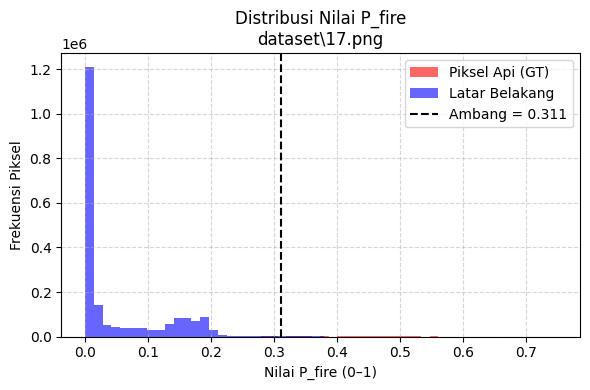

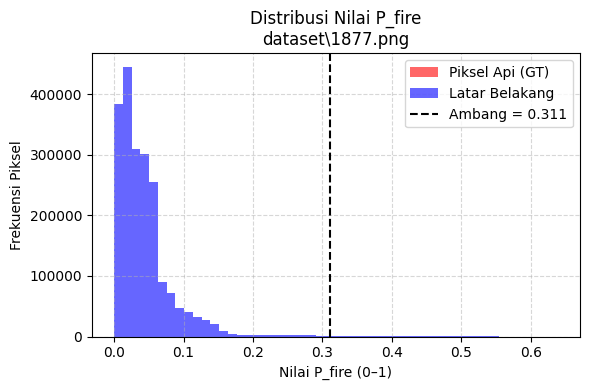

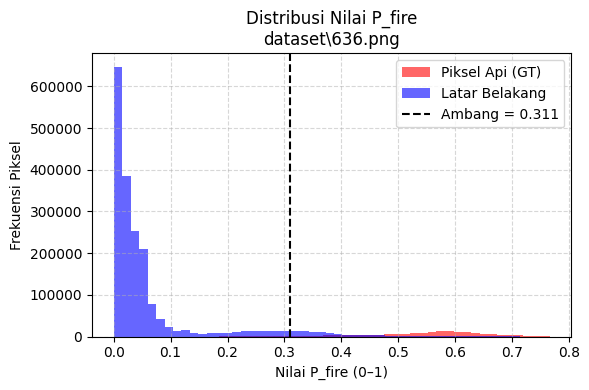

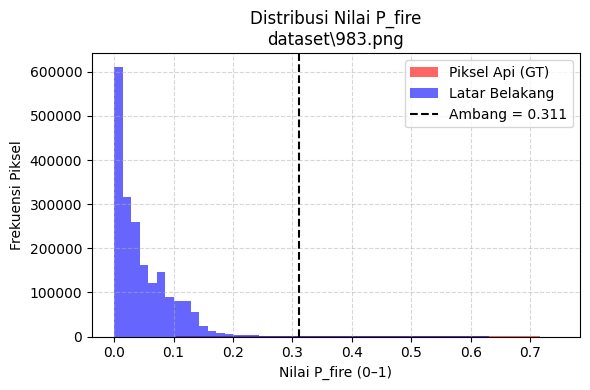

Distribusi Api: μ=0.4928, σ=0.1492
Distribusi Latar Belakang: μ=0.0522, σ=0.0743
Ambang Optimal (Maximum Likelihood): 0.3106


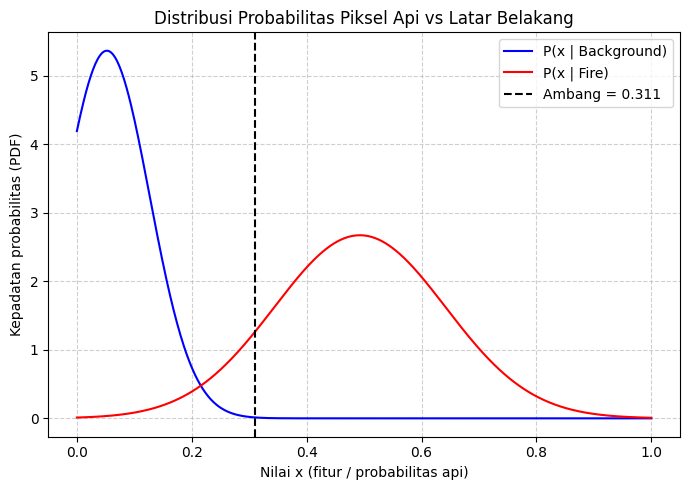

Memproses citra: dataset\17.png


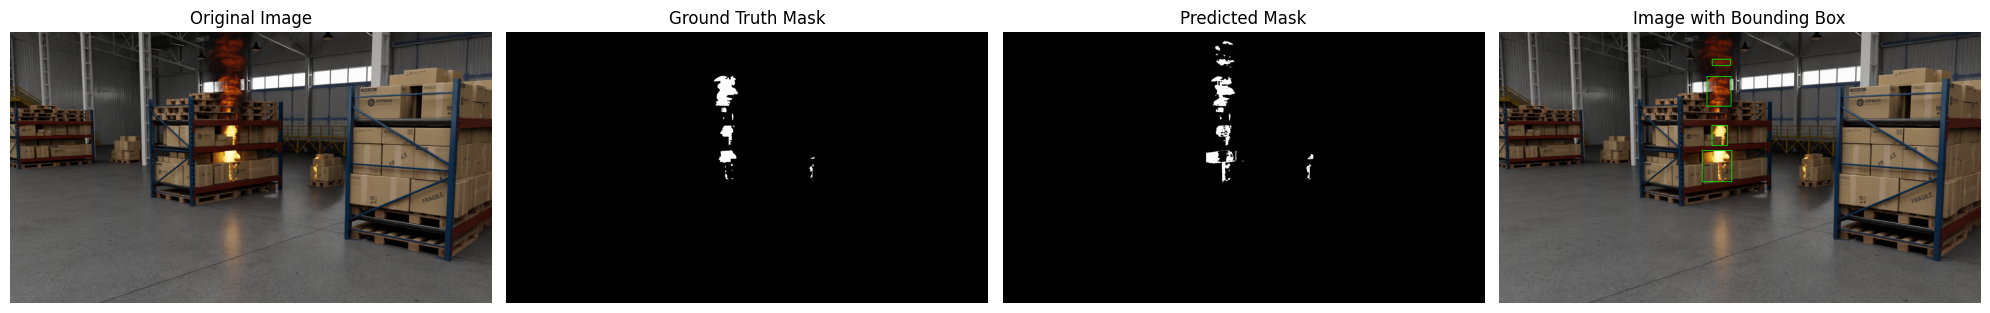

IoU: 0.4827, Akurasi: 0.9952
Memproses citra: dataset\1877.png


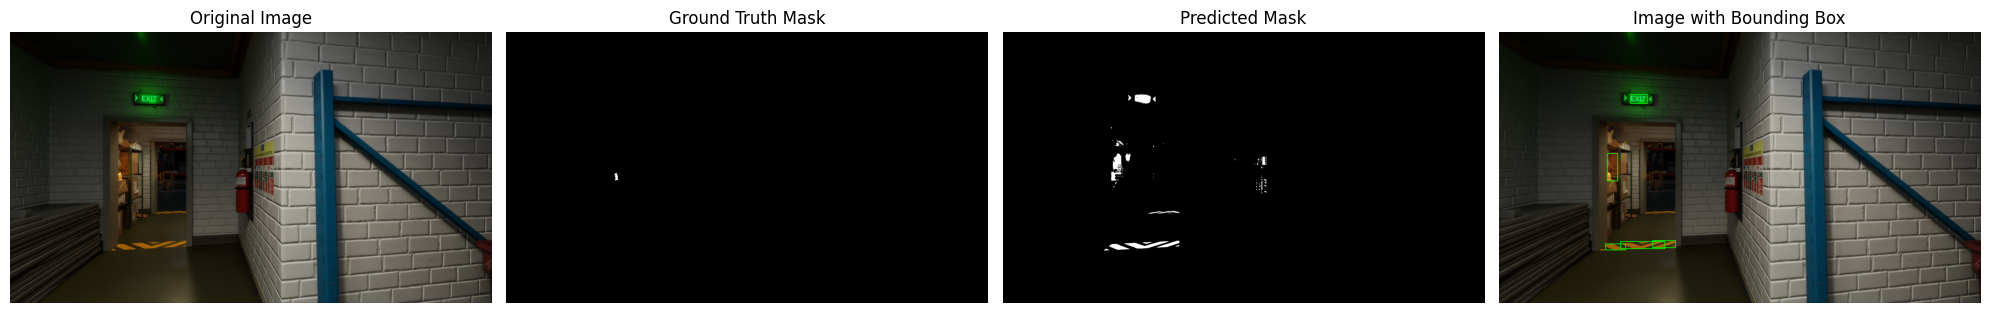

IoU: 0.0245, Akurasi: 0.9946
Memproses citra: dataset\636.png


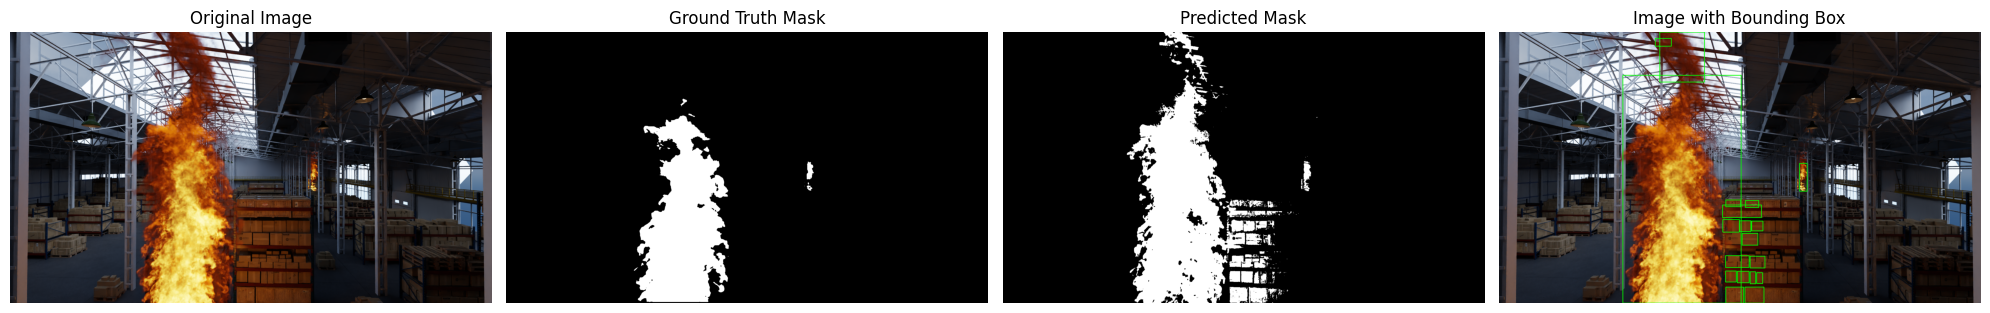

IoU: 0.5961, Akurasi: 0.9457
Memproses citra: dataset\983.png


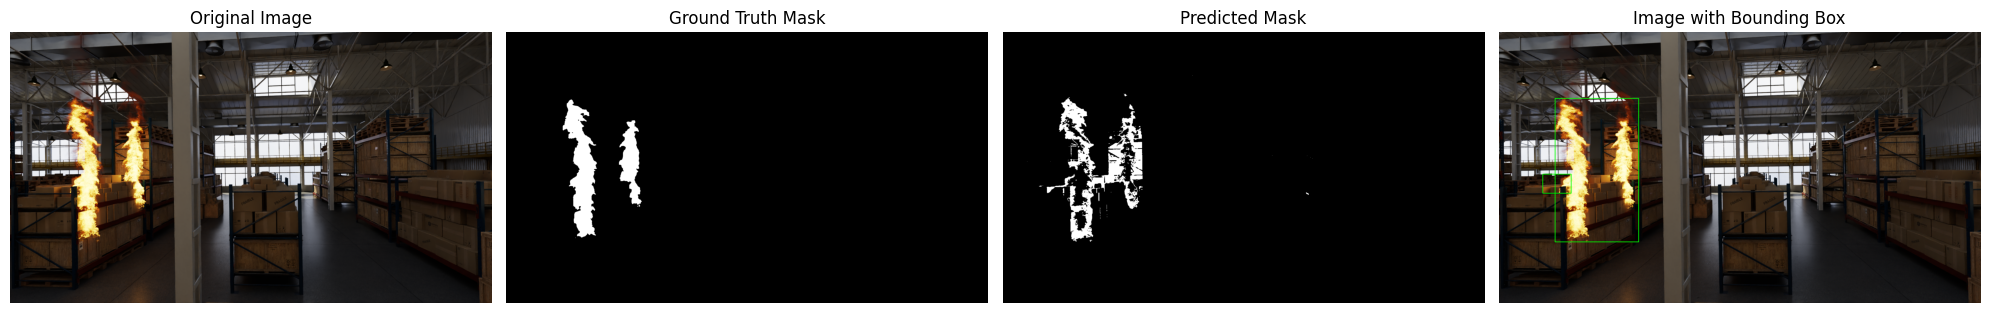

IoU: 0.3645, Akurasi: 0.9759
Rata-rata IoU: 0.3670
Rata-rata Akurasi: 0.9779


In [ ]:
fire_params, bkg_params = estimate_fire_background_pdfs(images)
opt_thresh = derive_optimal_threshold(fire_params, bkg_params, p_fire=0.01)

ious, accs = [], []

for img_path in images:
    print(f"Memproses citra: {img_path}")
    img = cv2.imread(img_path)
    mask_path = img_path.replace('.png', '_mask.png')
    gt = cv2.imread(mask_path, 0)
    if gt is None:
        continue
    gt = (gt > 128).astype(np.uint8)

    pred = fire_probability_mask(img, opt_thresh)
    img_with_box = draw_bounding_box(img, pred)
    draw_processed_image(img, gt, pred, img_with_box, name=img_path.split('/')[-1])

    iou = IoU(pred, gt)
    acc = np.mean(pred == gt)
    print(f"IoU: {iou:.4f}, Akurasi: {acc:.4f}")
    ious.append(iou); accs.append(acc)

print(f"Rata-rata IoU: {np.mean(ious):.4f}")
print(f"Rata-rata Akurasi: {np.mean(accs):.4f}")